In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# !pip install tqdm
# curl -O https://files.grouplens.org/datasets/movielens/ml-25m.zip

In [4]:
import re
import tqdm

In [5]:


dataset_movielen_url = "/home/quang/Two-stages-recommendation-system/datasets/ml-25m/"

movies_df = pd.read_csv(dataset_movielen_url + "movies.csv")
ratings_df =  pd.read_csv(dataset_movielen_url + "ratings.csv")



In [6]:
# genres_list  = set("|".join(movies_df["genres"]).split("|"))
# print(f"Unique genres: {genres_list }")
genres_list = ['Sci-Fi', 'Film-Noir', 'Children', 'Crime', 'Adventure', 'Musical', 'Horror', 'Thriller', 'Documentary', 'Animation', 'Mystery', 'Romance', 'Fantasy', 'IMAX', 'Drama', '(no genres listed)', 'Action', 'War', 'Western', 'Comedy']


In [7]:
movies_df['year'] = 0
movies_df['year'] = movies_df['year'].astype(int)

for genre in genres_list:
    movies_df[genre] = 0
    movies_df[genre] = movies_df[genre].astype(int)

In [8]:
def one_hot_encoding(df):
    for index, row in tqdm.tqdm(df.iterrows()):
        movieId = index 
        title = row.title

        # Extract year from title
        matcher = re.compile(r'\s*\(\d{4}\)')
        if matcher.search(title) is not None:
            parenthesis_year = matcher.search(title).group(0)
            matcher = re.compile(r'\s*\d{4}')
            year = matcher.search(parenthesis_year).group(0)
            df.loc[index, 'year'] = int(year)
            df.loc[index, 'title'] = re.sub(r'\s*\(\d{4}\)', "", title)

        # Handle genre column
        try:
            genres = row.genres.split('|') 
        except Exception:
            genres = list(row.genres)

        # One-hot encode genres
        for genre in genres:
            df.loc[index, genre] = 1  

    return df

In [9]:
movies_df = one_hot_encoding(movies_df)

62423it [01:23, 751.12it/s]


In [10]:
movies_df = movies_df.drop('genres', axis=1)
movies_df.head()

,movieId,title,year,Sci-Fi,Film-Noir,Children,Crime,Adventure,Musical,Horror,...,Mystery,Romance,Fantasy,IMAX,Drama,(no genres listed),Action,War,Western,Comedy
0,1,Toy Story,1995,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,Waiting to Exhale,1995,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
4,5,Father of the Bride Part II,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             62423 non-null  int64 
 1   title               62423 non-null  object
 2   year                62423 non-null  int64 
 3   Sci-Fi              62423 non-null  int64 
 4   Film-Noir           62423 non-null  int64 
 5   Children            62423 non-null  int64 
 6   Crime               62423 non-null  int64 
 7   Adventure           62423 non-null  int64 
 8   Musical             62423 non-null  int64 
 9   Horror              62423 non-null  int64 
 10  Thriller            62423 non-null  int64 
 11  Documentary         62423 non-null  int64 
 12  Animation           62423 non-null  int64 
 13  Mystery             62423 non-null  int64 
 14  Romance             62423 non-null  int64 
 15  Fantasy             62423 non-null  int64 
 16  IMAX                62

In [12]:
ratings_df_grouped = ratings_df.groupby('movieId').agg({'rating': ['mean', 'std', 'count']})
ratings_df_grouped.columns = ['rating_mean', 'rating_std', 'rating_count']
ratings_df_grouped['rating_count'] = ratings_df_grouped['rating_count'].astype(int)
ratings_df_grouped.head()

,rating_mean,rating_std,rating_count
movieId,,,
1,3.893708,0.921552,57309
2,3.251527,0.959851,24228
3,3.142028,1.008443,11804
4,2.853547,1.108531,2523
5,3.058434,0.996611,11714


In [13]:
ratings_df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59047 entries, 1 to 209171
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rating_mean   59047 non-null  float64
 1   rating_std    48749 non-null  float64
 2   rating_count  59047 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.8 MB


In [14]:

ratings_df_grouped[(ratings_df_grouped['rating_std'].isnull()) & (ratings_df_grouped['rating_count'] != 1)]

,rating_mean,rating_std,rating_count
movieId,,,


In [15]:
ratings_df_grouped['rating_std'] = ratings_df_grouped['rating_std'].fillna(0)

In [16]:
movies_df = movies_df.join(ratings_df_grouped)

In [17]:
movies_df.head()

,movieId,title,year,Sci-Fi,Film-Noir,Children,Crime,Adventure,Musical,Horror,...,IMAX,Drama,(no genres listed),Action,War,Western,Comedy,rating_mean,rating_std,rating_count
0,1,Toy Story,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,NaN,NaN,NaN
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,3.893708,0.921552,57309.0
2,3,Grumpier Old Men,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3.251527,0.959851,24228.0
3,4,Waiting to Exhale,1995,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,3.142028,1.008443,11804.0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2.853547,1.108531,2523.0


In [18]:
movies_df.to_csv(dataset_movielen_url + 'movies_mod.csv')

In [19]:
genome_tags_df = pd.read_csv(dataset_movielen_url + "genome-tags.csv")
genome_scores_df = pd.read_csv(dataset_movielen_url + "genome-scores.csv")

In [20]:
genome_tags_df.tag.values

array(['007', '007 (series)', '18th century', ..., 'wwii', 'zombie',
       'zombies'], dtype=object)

In [21]:
genome_scores_df = genome_scores_df.pivot(index='movieId', columns='tagId', values='relevance')

In [22]:
genome_scores_df.columns = genome_tags_df.tag.values
genome_scores_df.head()

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,0.03075,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
2,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,0.05250,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
3,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,0.03875,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
4,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,0.03150,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
5,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,0.02975,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


In [23]:
genome_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13816 entries, 1 to 206499
Columns: 1128 entries, 007 to zombies
dtypes: float64(1128)
memory usage: 119.0 MB


In [24]:
genome_scores_df.to_csv(dataset_movielen_url + 'genome-pivot.csv')

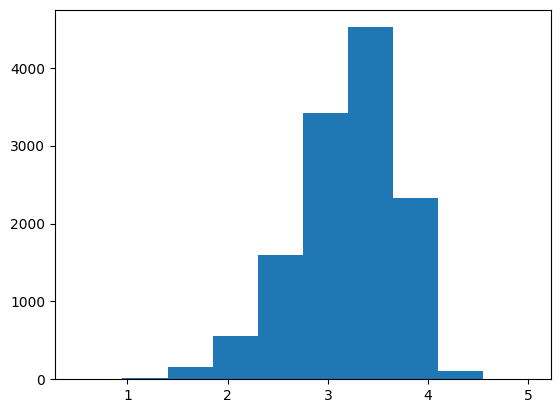

In [25]:
movies_df.rating_mean.hist(bins=10)
plt.grid(False)
plt.show()

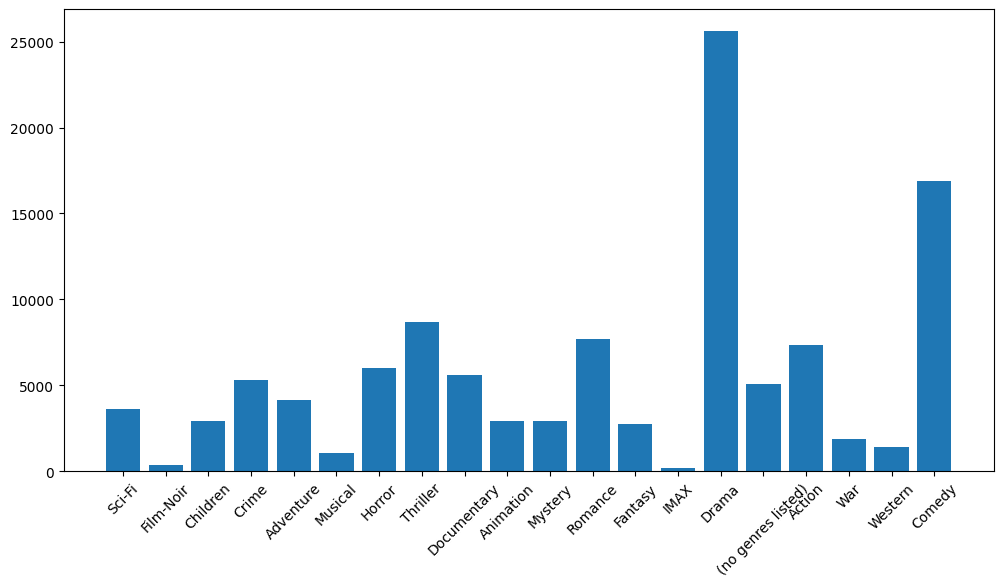

In [26]:
plt.figure(figsize=(12,6))
plt.bar(movies_df[genres_list].sum().index, movies_df[genres_list].sum().values)
plt.xticks(rotation = 45)
plt.show()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


: 